In [9]:
import warnings
import numpy as np
import xarray as xr
from numba import jit
import proplot as pplt
from datetime import datetime
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
warnings.filterwarnings('ignore')

In [10]:
FILEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
BINRANGE     = (-0.6,0.05)
PRTHRESH     = 0.25
SAMPLETHRESH = 50
PRTHRESH     = 0.25
TESTSIZE     = 0.2
RANDOMSTATE  = 42
BINWIDTHS  = [0.001,0.002,0.01,0.02,0.1,0.2]
MARKERS    = ['o', 's','^','D','*','p']
COLORS     = ['C0','C1','C2','C3','C4','C5'] 

In [11]:
def load(filename,xname,yname,filedir=FILEDIR,testsize=TESTSIZE,randomstate=RANDOMSTATE):
    data = xr.open_dataset(f'{filedir}/{filename}')
    x = data[xname].load()
    y = data[yname].load()
    timeidxs = np.arange(x.time.size)
    trainidxs,testidxs = train_test_split(timeidxs,test_size=testsize,random_state=randomstate)
    xtrain = x[trainidxs].values.flatten().astype(np.float64)
    ytrain = y[trainidxs].values.flatten().astype(np.float64)
    xtest  = x[testidxs].values.flatten().astype(np.float64)
    ytest  = y[testidxs].values.flatten().astype(np.float64)
    return xtrain,ytrain,xtest,ytest

@jit(nopython=True)
def fast_binned_stats(blidxs,prvals,nblbins,prthresh=PRTHRESH):
    Q0 = np.zeros(nblbins)
    QE = np.zeros(nblbins)
    Q1 = np.zeros(nblbins)
    for i in range(prvals.size):
        blidx = blidxs.flat[i]
        prval = prvals.flat[i]
        if 0<=blidx<nblbins and np.isfinite(prval):
            Q0[blidx] += 1
            Q1[blidx] += prval
            if prval>prthresh:
                QE[blidx] += 1
    return Q0,QE,Q1

def calc_binned_stats(x,y,binwidth,binrange=BINRANGE):
    ds = xr.Dataset()
    blbins = np.arange(binrange[0],binrange[1]+binwidth,binwidth)
    blidxs = ((x-binrange[0])/binwidth+0.5).astype(np.int32)
    Q0,QE,Q1 = fast_binned_stats(blidxs,y,blbins.size)
    ds['Q0'] = ('bl',Q0)
    ds['QE'] = ('bl',QE)
    ds['Q1'] = ('bl',Q1)
    ds['bl'] = blbins
    return ds

def get_bin_mean_pr(stats,samplethresh=SAMPLETHRESH):
    blbins = stats.bl.values
    Q0     = stats.Q0.values
    Q1     = stats.Q1.values
    Q0[Q0==0.0] = np.nan
    binmeanpr = Q1/Q0
    binmeanpr[Q0<samplethresh] = np.nan
    return xr.DataArray(binmeanpr,coords={'bl':blbins})

def predict_pr(blvals,binmeanpr):
    blbins = binmeanpr.bl.values
    predpr = np.interp(blvals,blbins,binmeanpr.values,left=np.nan,right=np.nan)
    return predpr

def compute_metrics(ytrue,ypred):
    mask = ~np.isnan(ytrue)&~np.isnan(ypred)
    ytrueclean = ytrue[mask]
    ypredclean = ypred[mask]

    

    
    r2   = r2_score(ytrueclean,ypredclean)
    mse  = mean_squared_error(ytrueclean,ypredclean)
    rmse = (mean_squared_error(ytrueclean,ypredclean))**2
    mae  = mean_absolute_error(ytrueclean,ypredclean)
    histtrue,_ = np.histogram(ytrueclean,bins=50,density=True)
    histpred,_ = np.histogram(ypredclean,bins=50,density=True)
    hellinger  = np.sqrt(np.sum((np.sqrt(histtrue)-np.sqrt(histpred))**2))/np.sqrt(2)
    return r2,mse,rmse,mae,hellinger

In [12]:
data = xr.open_dataset(f'{FILEDIR}/HR_ERA5_IMERG_pr_bl_terms.nc')
data = data[['pr','bl']].load()

In [13]:
xtrain,ytrain,xtest,ytest = load(filename='LR_ERA5_IMERG_pr_bl_terms.nc',xname='bl',yname='pr')

In [14]:
# from scipy import optimize

# def ramp_function(bl,alpha,bc):
#     return alpha*np.maximum(bl-bc,0)

# def fit_ramp_function(binmeanpr,bcguess=-0.05):
#     bl = binmeanpr.bl.values
#     pr = binmeanpr.values
#     mask = ~np.isnan(pr)
#     bl = bl[mask]
#     pr = pr[mask]
#     nonzeroidx = np.argmax(pr>0)
#     while nonzeroidx<len(pr)-1 and pr[nonzeroidx+1]==0:
#         nonzeroidx += 1
#     blfit = bl[nonzeroidx:]
#     prfit = pr[nonzeroidx:]
#     def objective(params):
#         alpha,bc = params
#         return np.sum((ramp_function(blfit,alpha,bc)-prfit)**2)
#     initguess = [np.mean(prfit)/np.mean(blfit),bcguess]
#     bounds = [(0,None),(-0.1,0)]
#     result = optimize.minimize(objective,initguess,bounds=bounds,method='L-BFGS-B')
#     alpha,bc = result.x
#     return alpha,bc

# # stats     = calc_binned_stats(data.bl.values.flatten(),data.pr.values.flatten(),binwidth=0.0025)
# # binmeanpr = get_bin_mean_pr(stats)
# # alpha,bc  = fit_ramp_function(binmeanpr)

# # blcontin = np.linspace(binmeanpr.bl.min(),binmeanpr.bl.max(),1000)
# # prramp   = ramp_function(blcontin,alpha,bc)

# fig,ax = pplt.subplots(nrows=1,ncols=1)
# ax.format(xlabel='$\mathit{B_L}$',ylabel='Precipitation (mm/day)')
# ax.scatter(binmeanpr.bl,binmeanpr,label='Empirical')
# ax.plot(blcontin,prramp,'r-',label='Fit')
# ax.text(0.05,0.8,f'α = {alpha:.1f}',transform=plt.gca().transAxes,va='top')
# ax.text(0.05,0.73,f'$B_c$ = {bc:.4f}',transform=plt.gca().transAxes,va='top')
# ax.legend(loc='ul',ncols=1)
# pplt.show()

In [15]:
results = []
for binwidth in BINWIDTHS:
    print(f'Working on {binwidth}...')
    trainstats = calc_binned_stats(xtrain,ytrain,binwidth=binwidth)
    binmeanpr  = get_bin_mean_pr(trainstats)
    predpr = predict_pr(xtest,binmeanpr)
    truepr = ytest
    r2,mse,rmse,mae,hellinger = compute_metrics(truepr,predpr)
    results.append({'binwidth':binwidth,
                    'nparams':binmeanpr.bl.size,
                    'binmeanpr':binmeanpr,
                    'truepr':truepr,
                    'predpr':predpr,
                    'r2':r2,
                    'mse':mse,
                    'rmse':rmse,
                    'mae':mae,
                    'hellinger':hellinger})

Working on 0.001...
Working on 0.002...
Working on 0.01...
Working on 0.02...
Working on 0.1...
Working on 0.2...


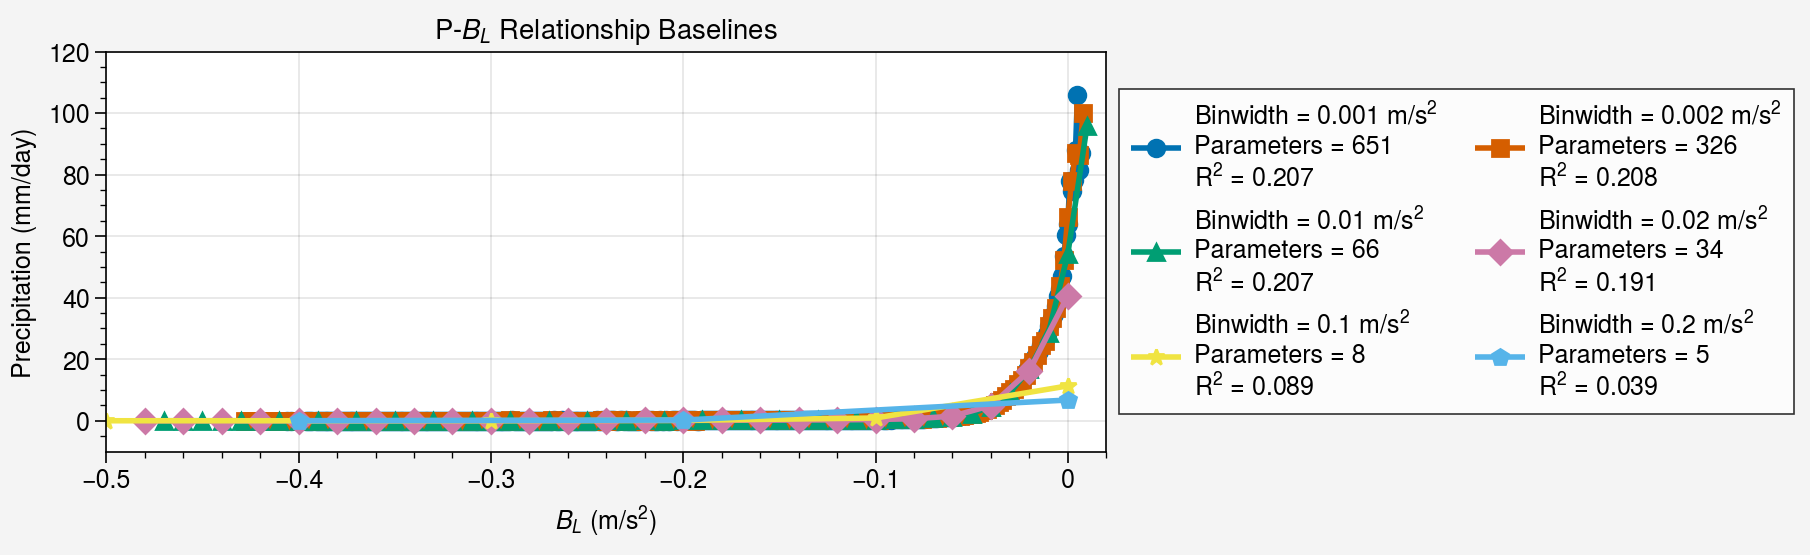

In [20]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=5,refheight=2)
ax.format(title='P-$\mathit{B_L}$ Relationship Baselines',
          xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.5,0.02),ylabel='Precipitation (mm/day)',ylim=(-10,120))
for i,result in enumerate(results):
    ax.plot(result['binmeanpr'],color=COLORS[i],markers=MARKERS[i],linewidth=2,
            label=f"Binwidth = {result['binwidth']} m/s$^2$\nParameters = {result['nparams']}\nR$^2$ = {result['r2']:.3f}")
ax.legend(loc='r',ncols=2)
pplt.show()

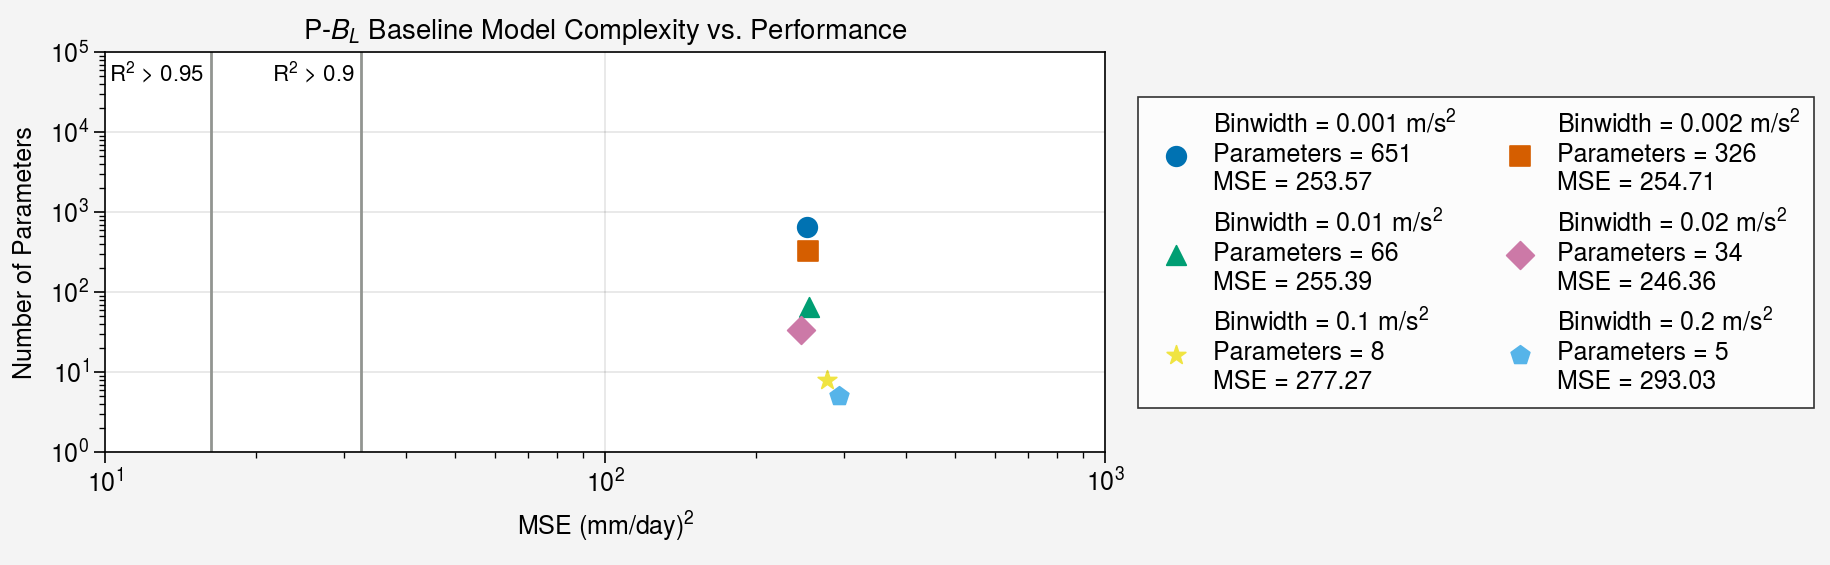

In [42]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=5,refheight=2)
ax.format(title='P-$\mathit{B_L}$ Baseline Model Complexity vs. Performance',
          xlabel='MSE (mm/day)$^2$',xscale='log',xformatter='log',xlim=(1e1,1e3),
          ylabel='Number of Parameters',yscale='log',yformatter='log',ylim=(1e0,1e5))
for i,result in enumerate(results):
    ax.scatter(result['mse'],result['nparams'],color=COLORS[i],marker=MARKERS[i],markersize=50,
               label=f"Binwidth = {result['binwidth']} m/s$^2$\nParameters = {result['nparams']}\nMSE = {result['mse']:.2f}")
truevar = np.var(results[0]['truepr'])
r209    = truevar*(1-0.9)
r2095   = truevar*(1-0.95)
ax.axvline(x=r209,color='gray',linewidth=1)
ax.axvline(x=r2095,color='gray',linewidth=1)
ax.text(r209*0.97,ax.get_ylim()[1]*0.8,'R$^2$ > 0.9',color='k',va='top',ha='right',fontsize=8)
ax.text(r2095*0.97,ax.get_ylim()[1]*0.8,'R$^2$ > 0.95',color='k',va='top',ha='right',fontsize=8)
ax.legend(loc='r',ncols=2)
pplt.show()

MSE is more sensitive to outliers than R². More complex models might be fitting to outliers or extreme values, increasing their MSE despite better overall correlation.

Simpler models (larger binwidths) might be biased but have lower variance.
This could result in predictions that are "wrong" but consistently so, leading to lower MSE.


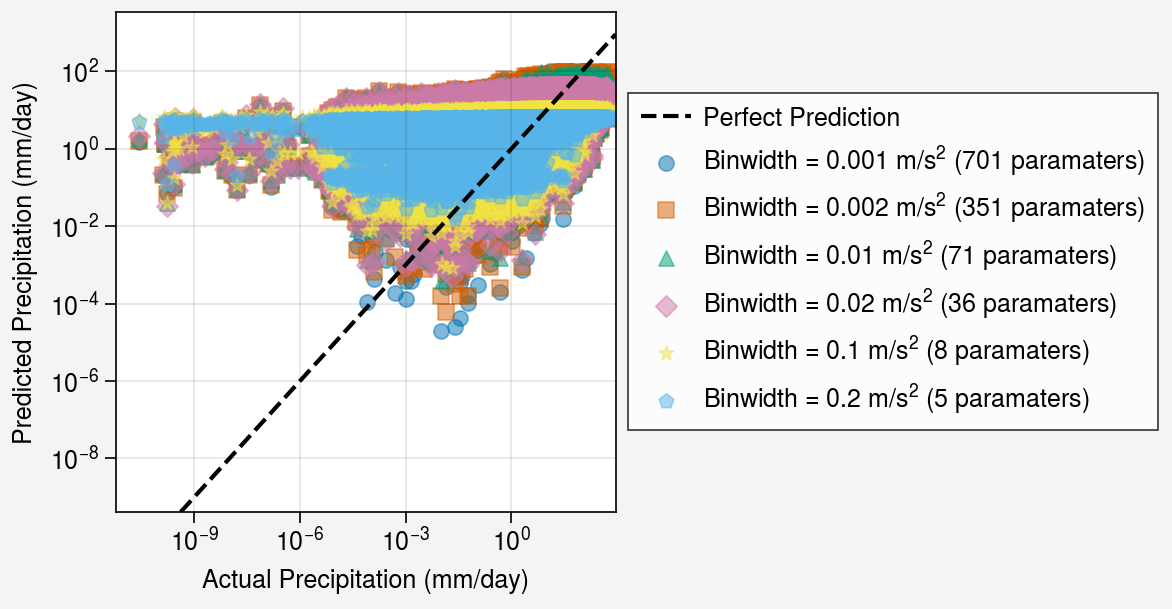

In [27]:
fig,ax = pplt.subplots(nrows=1,ncols=1)
for i,result in enumerate(results):
    binwidth = result['binwidth']
    nparams  = result['nparams']
    truepr   = result['truepr'].flatten() 
    predpr   = result['predpr'].flatten()
    # sampleidxs = np.random.choice(len(truepr),1000,replace=False)
    ax.scatter(truepr,predpr,color=COLORS[i],marker=MARKERS[i],markersize=30,alpha=0.5,    
               label=f"Binwidth = {binwidth} m/s$^2$ ({nparams} paramaters)")
maxval = max(ax.get_xlim()[1],ax.get_ylim()[1])
ax.plot([0,maxval],[0,maxval],'k--',label='Perfect Prediction')
ax.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xformatter='log',
          ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log')
ax.legend(loc='r',ncols=1)
pplt.show()